# Marketing Campaign Dataset - Models

## Abstract

In this notebook initial models for the data are tested. The preprocessing developed in other notebooks to transform the data is used. 

## Initialization (libraries, functions, paths)

### Data path

In [208]:
data_path = "../Dataset/marketing_campaign_available.csv"

### Library imports

In [209]:
# Data manipulation
import pandas as pd
import numpy as np
from datetime import datetime

# Missing data treatment
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Normalization
from sklearn.preprocessing import StandardScaler

# Split data
from sklearn.model_selection import train_test_split

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Evaluation
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Visualization
import matplotlib.pyplot as plt

### Preprocessing functions

In [210]:
def read_data(path):
    data = pd.read_csv(path, sep=";")
    return data

def feature_selection(data):
    # Variables that will be deleted from the dataset
    remove_list = ['ID', 'Year_Birth', 'NumDealsPurchases', 'NumStorePurchases',
                   'NumWebVisitsMonth', 'Complain', 'Z_CostContact', 'Z_Revenue']
    
    # Deleting the variables from the dataset
    return data.drop(remove_list, axis=1)

def feature_engineering(data):
    # Marital_Status =======================================
    # ======================================================
    
    # Merging the least frequent categories in Marital_Status
    data['Marital_Status'] = data['Marital_Status'].replace(['YOLO', 'Absurd', 'Alone'], 'Others')

    # Dt_Customer ==========================================
    # ======================================================

    # Convert to datetime
    date_objects = [datetime.strptime(date_str, "%Y-%m-%d") for date_str in data['Dt_Customer']]

    # The target date
    target_date = datetime(2023, 1, 1)

    # Calculate the difference in days between each date and the target date
    days_passed = [(target_date - date_object).days for date_object in date_objects]

    # Update the column
    data['Dt_Customer'] = days_passed
    
    return data
    
def outlier_treatment(data):
    # Determining which are outliers
    condition = data['Income'] == 666666
    
    # Setting outlier to NaN
    data.loc[condition, 'Income'] = np.nan
    
    return data

def split_data(data):
    # Separating the data from the response
    X = data.drop(['Response'], axis=1)
    y = data['Response']
    
    # Splitting the data with a fixed seed for reproducibility
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=data['Response'])
    
    return X_train, X_test, y_train, y_test

def imputation(X_train, X_test):
    # Select numeric columns
    numeric_cols = X_train.select_dtypes(include=np.number).columns.tolist()

    # Initialize the imputer
    iter_imputer = IterativeImputer(random_state=42)

    # Fit the imputer with the training data
    iter_imputer.fit(X_train[numeric_cols])
    
    # Impute the data
    X_train[numeric_cols] = iter_imputer.transform(X_train[numeric_cols])
    X_test[numeric_cols] = iter_imputer.transform(X_test[numeric_cols])
    
    return X_train, X_test

def normalization(X_train, X_test):
    # Select numeric columns
    numeric_cols = X_train.select_dtypes(include=np.number).columns.tolist()
    
    # Create the scaler
    scaler = StandardScaler()

    # Fit the scaler with the training data
    scaler.fit(X_train[numeric_cols])
    
    # Normalize the data
    X_train[numeric_cols] = scaler.transform(X_train[numeric_cols])
    X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])
    
    return X_train, X_test

def encoding(X_train, X_test):
    # One-hot encoding for categorical variables
    X_train = pd.get_dummies(X_train, columns=['Education', 'Marital_Status'], prefix=['Edu', 'MS'])
    X_test = pd.get_dummies(X_test, columns=['Education', 'Marital_Status'], prefix=['Edu', 'MS'])
    
    return X_train, X_test

### Evaluation functions

In [211]:
def evaluate_model(y_train_real, y_train_pred, y_test_real, y_test_pred,
                   model=None, X_train=None, n_folds=0):
    # Calculating train scores
    if n_folds: # With Cross Validation
        folds = KFold(n_splits=n_folds, shuffle=True, random_state=42)
        train_acc = cross_val_score(model, X_train, y_train_real, scoring="accuracy", cv=folds)
        train_f1 = cross_val_score(model, X_train, y_train_real, scoring="f1", cv=folds)
    else: # Without Cross Validation
        train_acc = accuracy_score(y_train_real, y_train_pred)
        train_f1 = f1_score(y_train_real, y_train_pred)

    # Calculating test scores
    test_acc = accuracy_score(y_test_real, y_test_pred)
    test_f1 = f1_score(y_test_real, y_test_pred)
    
    return train_acc, train_f1, test_acc, test_f1

def plot_confusion_matrix(y_real, y_pred):
    # Claculating the confusion matrix
    model_confusion_matrix = confusion_matrix(y_real, y_pred)

    # Creating the plot
    cm_plot = ConfusionMatrixDisplay(confusion_matrix=model_confusion_matrix,
                                  display_labels=['0', '1'])

    # Adjusting the plot and plotting
    fig, ax = plt.subplots(figsize=(5,3))
    cm_plot.plot(ax=ax)

## Initial model 1 (No model/ Frequency model)

A dumb model would always choose the most frequent target value in the training dataset.

### Preprocessing step

In [212]:
data = read_data(data_path)
data = feature_selection(data)
data = feature_engineering(data)
data = outlier_treatment(data)
X_train, X_test, y_train, y_test = split_data(data)
X_train, X_test = imputation(X_train, X_test)
X_train, X_test = normalization(X_train, X_test)
X_train, X_test = encoding(X_train, X_test)

y_train.value_counts()

Response
0    1377
1     235
Name: count, dtype: int64

### Implementation and prediction

In this case, the most frequent value is "0"

So the accuracy in the test set would simply correspond to the fraction of "0" in the response column:

In [213]:
# Calculating the most frequent label in the response test set
label_frequencies_test = y_test.value_counts()/len(y_test)
label_frequencies_test

Response
0    0.85396
1    0.14604
Name: count, dtype: float64

In [214]:
# The prediction is a vector with the same value in all positions
y_test_pred = [np.argmax(label_frequencies_test)]*len(y_test)
y_test_pred[0:15]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [215]:
# Predictions for the training set can also be generated
label_frequencies_train = y_train.value_counts()/len(y_train)
y_train_pred = [np.argmax(label_frequencies_train)]*len(y_train)
y_train_pred[0:15]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

### Results

In [216]:
train_acc, train_f1, test_acc, test_f1 = evaluate_model(y_train, y_train_pred, y_test, y_test_pred)

full_results = pd.DataFrame({
    'Model': ['Frequency (Baseline)'],
    'Train Accuracy Mean': [np.mean(train_acc)],
    'Train Accuracy Std': np.nan,
    'Train F1 Mean': [np.mean(train_f1)],
    'Train F1 Std': np.nan,
    'Test Accuracy': [test_acc],
    'Test F1': [test_f1]
})

print("Frequency model train accuracy:", train_acc)
print("Frequency model train F1:", train_f1)

print("Frequency model test accuracy:", test_acc)
print("Frequency model test F1:", test_f1)

Frequency model train accuracy: 0.8542183622828784
Frequency model train F1: 0.0
Frequency model test accuracy: 0.8539603960396039
Frequency model test F1: 0.0


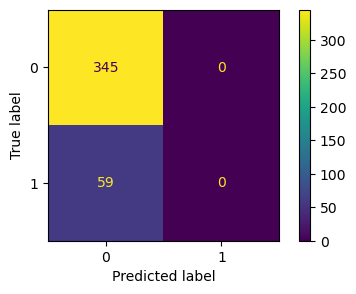

In [217]:
plot_confusion_matrix(y_test, y_test_pred)

## Inital Model 2 (Logistic Regression)

### Preprocessing step

In [218]:
data = read_data(data_path)
data = feature_selection(data)
data = feature_engineering(data)
data = outlier_treatment(data)
X_train, X_test, y_train, y_test = split_data(data)
X_train, X_test = imputation(X_train, X_test)
X_train, X_test = normalization(X_train, X_test)
X_train, X_test = encoding(X_train, X_test)

### Implementation

In [219]:
logistic_model = LogisticRegression().fit(X_train, y_train)

### Predictions

In [220]:
y_train_pred = logistic_model.predict(X_train)
y_test_pred = logistic_model.predict(X_test)

### Results

In [221]:
train_acc, train_f1, test_acc, test_f1 = evaluate_model(y_train, y_train_pred, y_test, y_test_pred,
                                                       model=logistic_model, X_train=X_train, n_folds=5)

new_data = pd.DataFrame({
    'Model': ['Logistic Reg.'],
    'Train Accuracy Mean': [np.mean(train_acc)],
    'Train Accuracy Std': [np.std(train_acc)],
    'Train F1 Mean': [np.mean(train_f1)],
    'Train F1 Std': [np.std(train_f1)],
    'Test Accuracy': [test_acc],
    'Test F1': [test_f1]
})

full_results = pd.concat([full_results, new_data], ignore_index=True)

print("Frequency model train accuracy:", train_acc)
print("Frequency model train F1:", train_f1)

print("Frequency model test accuracy:", test_acc)
print("Frequency model test F1:", test_f1)

Frequency model train accuracy: [0.89473684 0.91021672 0.89440994 0.88198758 0.89130435]
Frequency model train F1: [0.54054054 0.64197531 0.55263158 0.47222222 0.54545455]
Frequency model test accuracy: 0.9158415841584159
Frequency model test F1: 0.6382978723404255


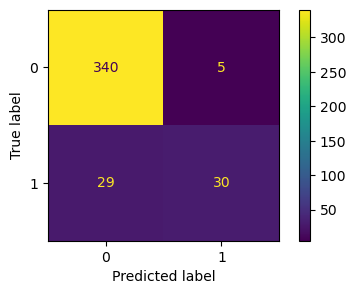

In [222]:
plot_confusion_matrix(y_test, y_test_pred)

## Inital model 3 (Random Forest)

### Preprocessing step

In [223]:
data = read_data(data_path)
data = feature_selection(data)
data = feature_engineering(data)
data = outlier_treatment(data)
X_train, X_test, y_train, y_test = split_data(data)
X_train, X_test = imputation(X_train, X_test)
X_train, X_test = normalization(X_train, X_test)
X_train, X_test = encoding(X_train, X_test)

### Implementation

In [224]:
# Initialize model
rf_model = RandomForestClassifier(n_estimators = 100, random_state=42)

# Fit model
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Prediction

In [225]:
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

### Results

In [226]:
train_acc, train_f1, test_acc, test_f1 = evaluate_model(y_train, y_train_pred, y_test, y_test_pred,
                                                       model=rf_model, X_train=X_train, n_folds=5)

new_data = pd.DataFrame({
    'Model': ['RF'],
    'Train Accuracy Mean': [np.mean(train_acc)],
    'Train Accuracy Std': [np.std(train_acc)],
    'Train F1 Mean': [np.mean(train_f1)],
    'Train F1 Std': [np.std(train_f1)],
    'Test Accuracy': [test_acc],
    'Test F1': [test_f1]
})

full_results = pd.concat([full_results, new_data], ignore_index=True)

print("Frequency model train accuracy:", train_acc)
print("Frequency model train F1:", train_f1)

print("Frequency model test accuracy:", test_acc)
print("Frequency model test F1:", test_f1)

Frequency model train accuracy: [0.88544892 0.87925697 0.88509317 0.8757764  0.88198758]
Frequency model train F1: [0.43076923 0.43478261 0.46376812 0.35483871 0.44117647]
Frequency model test accuracy: 0.8836633663366337
Frequency model test F1: 0.3561643835616438


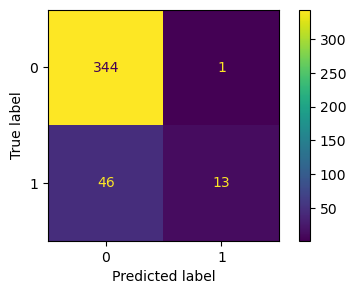

In [227]:
plot_confusion_matrix(y_test, y_test_pred)

## Model comparison

In [228]:
full_results

,Model,Train Accuracy Mean,Train Accuracy Std,Train F1 Mean,Train F1 Std,Test Accuracy,Test F1
0,Frequency (Baseline),0.854218,NaN,0.000000,NaN,0.853960,0.000000
1,Logistic Reg.,0.894531,0.009098,0.550565,0.054082,0.915842,0.638298
2,RF,0.881513,0.003648,0.425067,0.036922,0.883663,0.356164


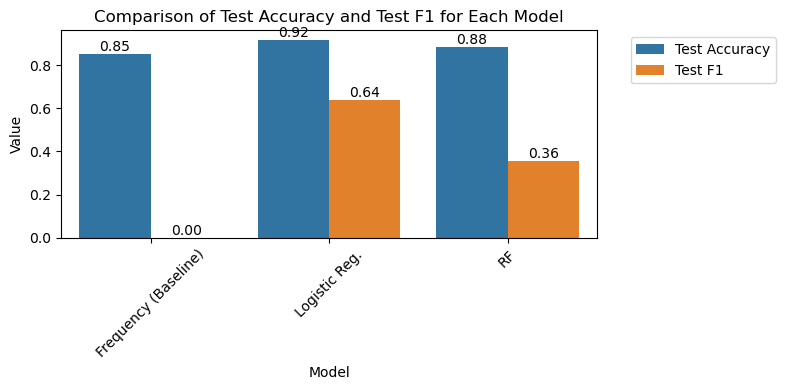

In [229]:
melted_data = full_results.melt(id_vars=['Model'], value_vars=['Test Accuracy', 'Test F1'],
                                var_name='Metric', value_name='Value')

plt.figure(figsize=(8, 4))
ax = sns.barplot(x='Model', y='Value', hue='Metric', data=melted_data)

for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height(), '{0:.2f}'.format(p.get_height()), 
            fontsize=10, ha='center', va='bottom')

plt.xticks(rotation=45)
plt.title('Comparison of Test Accuracy and Test F1 for Each Model')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()